In [99]:
## Cell 1
## Import modules
import iris
import matplotlib
import iris.quickplot as qplt
import iris.plot as iplt
from iris import *
from iris.analysis import *
from iris.analysis.cartography import *
from iris.coord_categorisation import *
import matplotlib.pyplot as plt
from scipy.stats import *
import sys
import numpy
import iris.coord_categorisation
from numpy import *
from matplotlib.pyplot import *
import matplotlib.lines as mlines
from scipy.stats.mstats import *
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import datetime as dt
import matplotlib.colors as colors
from matplotlib.ticker import PercentFormatter


In [100]:
## Cell 2
## Define important functions

## Extract year range (Cell 4 and )
def dhw_to_enso_event_timeline(dhw_cube,start_year,end_year):
    
    try:  
        iris.coord_categorisation.add_year(dhw_cube,'time', name='year')
    except:
        pass
        
    loc_dhw_cube = np.where((dhw_cube.coord('year').points >= start_year) & (dhw_cube.coord('year').points <= end_year))
    dhw_cube = dhw_cube[loc_dhw_cube]                                  # Extract those years into a new variable 
        
    return dhw_cube

## Calculate Annual max
def annual_max(cube):
    
    try:
        iris.coord_categorisation.add_year(cube,'time', name='year')
    except:
        pass
    return cube.aggregated_by('year',iris.analysis.MAX)

## Calculate Annual Mean
def annual_mean (cube):
    
    try:
        iris.coord_categorisation.add_year(cube,'time', name='year')
    except:
        pass
    
    return cube.aggregated_by('year',iris.analysis.MEAN)


## Calculate Area mean
def area_avg(cube):
    
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude', 'latitude'],iris.analysis.MEAN, weights=grid_areas)
    

## Define quadratic function for detrending (Cell)
def quadratic_function(x,a,b,c):    
    y = (a*(x**2.0)) + (b*x) + c
    return y


## Define function for calculating number of pixels in each DHW threshold 
def threshold_count (enso_event_cube_data,enso_event_dhw_negative_count,enso_event_dhw_0_to_1_count,enso_event_dhw_1_to_4_count,enso_event_dhw_4_to_8_count,enso_event_dhw_more_8_count):
    
    # Create for loop to examine all data
    for i in range(0,len(enso_event_cube_data)):
           
        # Define if statements to segment different threshold counts
        if (enso_event_cube_data[i] < 0):
            enso_event_dhw_negative_count = enso_event_dhw_negative_count + 1
    
        if (0 <= enso_event_cube_data[i] < 1):
            enso_event_dhw_0_to_1_count = enso_event_dhw_0_to_1_count + 1
        
        if (1 <= enso_event_cube_data[i] < 4):
            enso_event_dhw_1_to_4_count = enso_event_dhw_1_to_4_count + 1
        
        if (4 <= enso_event_cube_data[i] < 8):
            enso_event_dhw_4_to_8_count = enso_event_dhw_4_to_8_count + 1
        
        if (8 <= enso_event_cube_data[i]):
            enso_event_dhw_more_8_count = enso_event_dhw_more_8_count + 1
    
    return enso_event_dhw_negative_count, enso_event_dhw_0_to_1_count, enso_event_dhw_1_to_4_count, enso_event_dhw_4_to_8_count, enso_event_dhw_more_8_count


In [101]:
## Cell 3
## Read in daily DHW data

## Read in cube
dhw_cube = iris.load_cube('/data/local_ssd/cj362/S2P3Rv2.0/dhw/dhw_script_outputs/MIROC6_ssp245_daily_dhw.nc')
dhw_cube_name = "MIROC6 ssp2(4.5)"
# print(dhw_cube)

In [102]:
## Cell 4
## Remove year,month and month number as scalar coordinates
## Add back in year, month and month number as auxiliary coordinates 
## These steps are done in response to an error which causes later variables to be recognised...
## ...as NoneType objects rather than Iris Cubes.
## Must be run

# Remove as scalar cooridnates
try:
    dhw_cube.remove_coord('year')
except:
    pass
try:
    dhw_cube.remove_coord('month')
except: 
    pass
try:
    dhw_cube.remove_coord('month_number')
except:
    pass

# Add back in as auxiliary coordinates
try:  
    iris.coord_categorisation.add_year(dhw_cube,'time', name='year')
except:
    pass
try: 
    iris.coord_categorisation.add_month(dhw_cube,'time', name='month')
except:
    pass
try: 
    iris.coord_categorisation.add_month_number(dhw_cube,'time', name = 'month_number')
except:
      pass


In [103]:
## Cell 5
## Extract data for 2000 to 2090 time period

# Specify start and end years
start_year = 2000
end_year = 2090

# Call function to extract between above specified years
dhw_cube = dhw_to_enso_event_timeline(dhw_cube,start_year,end_year)

In [104]:
## Cell 6
## Convert points in the data mask to True

# Extract cube data
dhw_cube_data = dhw_cube.data


shape = np.shape(dhw_cube_data)                                        # Returns the shape of the array

# For loop iterates through data points
for i in range(shape[1]):                                  
    for j in range(shape[2]):
        # "any" looks in parameter to see if any of them are True or are False. 
        # all points in the mask will be True or False as that is what a mask is for
        if any(dhw_cube_data.mask[:,i,j]):
            dhw_cube.data.data[:,i,j] = dhw_cube.data.fill_value       # Converts the actual data point to None
            dhw_cube.data.mask[:,i,j] = True                           # Converts this point in the mask to True
                                                                       # true means it is read as missing value
                                                                       # and so is ignored

In [105]:
## Cell 7
## Convert daily data to annual (max) data

# Annual mean: used alone this does not capture the anomalous signal of extreme events like ENSO effectively
# this is becuse it is avergaed with values that are not that extreme (normal type values)
# whereas we are only interested in the extreme values

# annual mean
dhw_mean_cube = dhw_cube.copy()
dhw_mean_cube = annual_mean(dhw_cube)   # Call function

# Annual max: this directly captures the magnitude of extreme events that occur within a year
# Can be used with annual mean to detrmine how far the max departs from the annual mean baseline

# annual max
dhw_max_cube = dhw_cube.copy()
dhw_max_cube = annual_max(dhw_cube)     # Call function


In [106]:
## Cell 8a
## Detrending pt.1 (annual maximum)

## Re-load in dhw cube data for detrending
dhw_max_cube_detrend = dhw_max_cube.copy()                      # Copy annual maximum cube 
dhw_max_cube_detrend_data = dhw_max_cube_detrend.data           # Extract data
                                                                # Note: "detrend" (pre), not "detrended" (post)

## Detrending processing
max_shape = np.shape(dhw_max_cube_detrend_data)                 # Returns the shape of the array
output_max_cube_data = dhw_max_cube_detrend_data.copy()         # Seperate cube to process the data

for i in range(max_shape[1]):                                  
    for j in range(max_shape[2]):
        if dhw_max_cube_detrend_data.mask[0,i,j] == False:
            parameters, var = curve_fit(quadratic_function,np.arange(max_shape[0]),dhw_max_cube_detrend_data[:,i,j])
            y_values_anomaly_from_max_curve = quadratic_function(np.arange(max_shape[0]), *parameters)
            output_max_cube_data[:,i,j] = dhw_max_cube_detrend_data[:,i,j]-y_values_anomaly_from_max_curve

# Put detrended data back into usable variable
dhw_max_cube_detrended = dhw_max_cube_detrend.copy()             # Note:"detrended" (post), not "detrend" (pre)
dhw_max_cube_detrended.data = output_max_cube_data
dhw_max_cube_detrended_data = dhw_max_cube_detrended.data        # Specify new input data

In [107]:
## Cell 8b
## Detrending pt.2 (annual mean)

## Re-load in dhw cube data for detrending
dhw_mean_cube_detrend = dhw_mean_cube.copy()                      # Copy cube 
dhw_mean_cube_detrend_data = dhw_mean_cube_detrend.data           # Extract data
                                                                  # Note: "detrend" (pre), not "detrended" (post)

## Detrending processing
mean_shape = np.shape(dhw_mean_cube_detrend_data)                 # Returns the shape of the array
output_mean_cube_data = dhw_mean_cube_detrend_data.copy()         # Seperate cube to process the data

for i in range(mean_shape[1]):                                  
    for j in range(mean_shape[2]):
        if dhw_mean_cube_detrend_data.mask[0,i,j] == False:
            parameters, var = curve_fit(quadratic_function,np.arange(mean_shape[0]),dhw_mean_cube_detrend_data[:,i,j])
            y_values_anomaly_from_mean_curve = quadratic_function(np.arange(mean_shape[0]), *parameters)
            output_mean_cube_data[:,i,j] = dhw_mean_cube_detrend_data[:,i,j]-y_values_anomaly_from_mean_curve

# Put detrended data back into usable variable
dhw_mean_cube_detrended = dhw_mean_cube_detrend.copy()            # Note:"detrended" (post), not "detrend" (pre)
dhw_mean_cube_detrended.data = output_mean_cube_data
dhw_mean_cube_detrended_data = dhw_mean_cube_detrended.data       # Specify new input data


In [108]:
## Cell 9 

## Calculate area mean of annual maximum and annual mean values
# print(np.nanmin(dhw_max_cube_detrended_data))
# print(np.nanmax(dhw_max_cube_detrended_data))
dhw_max_cube_detrended_area_mean = area_avg(dhw_max_cube_detrended)             # Copy annual max dhw values
dhw_max_cube_detrended_area_mean_data = dhw_max_cube_detrended_area_mean.data   # Extract data
# print(np.nanmin(dhw_max_cube_detrended_area_mean_data))                       # Check min value changed
# print(np.nanmax(dhw_max_cube_detrended_area_mean_data))                       # Check max value changed
 
## Calculate area mean of annual mean values
# print(np.nanmin(dhw_mean_cube_detrended_data))
# print(np.nanmax(dhw_mean_cube_detrended_data))
dhw_mean_cube_detrended_area_mean = area_avg(dhw_mean_cube_detrended)           # Copy annual mean dhw values
dhw_mean_cube_detrended_area_mean_data = dhw_mean_cube_detrended_area_mean.data # Extract data
# print(np.nanmin(dhw_mean_cube_detrended_area_mean_data))                      # Check min value changed
# print(np.nanmax(dhw_mean_cube_detrended_area_mean_data))                      # Check max value changed

[2018, 2024, 2028, 2029, 2033, 2038, 2048, 2049, 2053, 2066, 2072, 2073, 2083]
[2021, 2025, 2039, 2044, 2046, 2059, 2065, 2073, 2080, 2083, 2088]


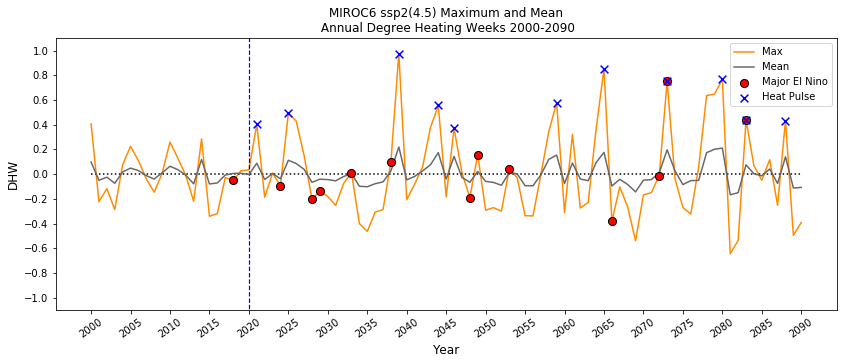

In [109]:
## Cell 8
## Plotting timeseries of annual max DHW values during identified ENSO events

## Determine quadratic line of best fit for annual maximum
parameters, var = curve_fit(quadratic_function,np.arange(max_shape[0]),dhw_max_cube_detrended_area_mean_data)
y_values_anomaly_from_max_curve = quadratic_function(np.arange(max_shape[0]), *parameters)
# plt.plot(dhw_max_cube_detrended_area_mean_data)
# plt.plot(y_values_anomaly_from_max_curve,'r')

## Determine quadratic line of best fit for annual mean
parameters, var = curve_fit(quadratic_function,np.arange(mean_shape[0]),dhw_mean_cube_detrended_area_mean_data)
y_values_anomaly_from_mean_curve = quadratic_function(np.arange(mean_shape[0]), *parameters)
# plt.plot(dhw_mean_cube_detrended_area_mean_data)
# plt.plot(y_values_anomaly_from_mean_curve,'r')


## Define PLotting variables
# X-axis
x_array =[]                                          # Year (x-axis)
for i in range(2000,2091):                           # Year 2000 to 2090
    x_array.append(i)

# Y-axis
y_array_1 = dhw_max_cube_detrended_area_mean_data    # Annual maximum DHW data
y_array_2 = dhw_mean_cube_detrended_area_mean_data   # Annual mean DHW data
y_array_3 = y_values_anomaly_from_mean_curve         # Detrending line (see above)

# print(np.nanmin(y_array_1))
# print(np.nanmax(y_array_1))

## Create variable for labelling investiated El Nino events for each model/scenario
## Also create final timeseries plot for each model/scenario
## GFDL-CM4 ssp2(4.5)
# Use as template for undertanding process for other model/scenarios below
if (dhw_cube_name == "GFDL-CM4 ssp2(4.5)"):
    enso_events_year_list = [30,52,58,78,85,88]                                     # Manually identified years for El Nino events from external data
    enso_events_dhw_value_list = []                                                 # Initialise list for dhw values
    heat_pulse_year_list = [30,46,68,79]
    heat_pulse_value_list = []
    for i in range (0, len(enso_events_year_list)):
        enso_events_dhw_value_index = enso_events_year_list[i]
        enso_events_dhw_value_list.append(y_array_1[enso_events_dhw_value_index])
    for i in range (0,len(heat_pulse_year_list)):
        heat_pulse_value_index = heat_pulse_year_list[i]
        heat_pulse_value_list.append(y_array_1[heat_pulse_value_index])
    # Adjust enso_events_year_list variable 
    # Makes the variable more suitable for scatter subplot of different El Nino events
    for i in range (0, len(enso_events_year_list)):
        enso_events_year_list[i] = enso_events_year_list[i] + 2000
    print(enso_events_year_list)
    for i in range (0, len(heat_pulse_year_list)):
        heat_pulse_year_list[i] = heat_pulse_year_list[i] + 2000
    print(heat_pulse_year_list)
  
    # Plotting timeseries
    fig, ax = plt.subplots(figsize=(14,5))
    ax.set_xlim(1998,2092)
    ax.set_ylim(-1.6,2.6)
    ax.plot(x_array, y_array_1, color='darkorange', linestyle='solid',label = "Max",zorder = 0)
    ax.plot(x_array, y_array_2, 'dimgray', label='Mean',zorder = 5)
    ax.scatter(enso_events_year_list,enso_events_dhw_value_list,s=65,c = "red",marker = "o",edgecolors="black",label = "Major El Nino",zorder = 10)
    ax.scatter(heat_pulse_year_list,heat_pulse_value_list,s=60,c="blue",marker="x",label="Heat Pulse",zorder=10)    
    plt.title("{0} Maximum and Mean\n Annual Degree Heating Weeks 2000-2090".format(dhw_cube_name))
    plt.xticks(np.arange(2000, 2095,step=5),rotation=35,fontsize="medium")  # Set label locations (2110 necessary in order to get 2100 label)
    plt.yticks(np.arange(-1.5,2.5,step=0.5),fontsize="medium")
    plt.xlabel("Year",fontsize="large")
    plt.ylabel("DHW",fontsize="large")
    plt.vlines(2020,-1.6,2.6,linestyle="dashed",linewidth=1.2,color="blue")
    plt.hlines(0,2000,2090,linestyle=":")
    ax.legend()
    # Save figure:
    plt.savefig("/data/local_ssd/cj362/S2P3Rv2.0/dhw/figures/GFDL-CM4_ssp2_enso_event_figures/{0}_enso_dhw_complete_timeseries.png".format(dhw_cube_name))

    
## GFDL-CM4 ssp5(8.5)
if (dhw_cube_name == "GFDL-CM4 ssp5(8.5)"):
    enso_events_year_list = [22,42,60,64,68,81]
    enso_events_dhw_value_list = []
    heat_pulse_year_list = [22,41,83]
    heat_pulse_value_list = []
    for i in range (0, len(enso_events_year_list)):
        enso_events_dhw_value_index = enso_events_year_list[i]
        enso_events_dhw_value_list.append(y_array_1[enso_events_dhw_value_index])
    for i in range (0,len(heat_pulse_year_list)):
        heat_pulse_value_index = heat_pulse_year_list[i]
        heat_pulse_value_list.append(y_array_1[heat_pulse_value_index])
    # Adjust enso_events_year_list variable 
    # Makes the variable more suitable for scatter subplot of different El Nino events
    for i in range (0, len(enso_events_year_list)):
        enso_events_year_list[i] = enso_events_year_list[i] + 2000
    print(enso_events_year_list)
    for i in range (0, len(heat_pulse_year_list)):
        heat_pulse_year_list[i] = heat_pulse_year_list[i] + 2000
    print(heat_pulse_year_list)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(14,5))
    ax.set_xlim(1998,2092)
    ax.set_ylim(-1.6,2.6)
    ax.plot(x_array, y_array_1, color='darkorange', linestyle='solid',label = "Max",zorder = 0)
    ax.plot(x_array, y_array_2, 'dimgray', label='Mean',zorder = 5)
    ax.scatter(enso_events_year_list,enso_events_dhw_value_list,s=65,c = "red",marker = "o",edgecolors="black",label = "Major El Nino",zorder = 10)
    ax.scatter(heat_pulse_year_list,heat_pulse_value_list,s=60,c="blue",marker="x",label="Heat Pulse",zorder=10)    
    plt.title("{0} Maximum and Mean\n Annual Degree Heating Weeks 2000-2090".format(dhw_cube_name))
    plt.xticks(np.arange(2000, 2095,step=5),rotation=35,fontsize="medium")  # Set label locations (2110 necessary in order to get 2100 label)
    plt.yticks(np.arange(-1.5,3.0,step=0.5),fontsize="medium")
    plt.xlabel("Year",fontsize="large")
    plt.ylabel("DHW",fontsize="large")
    plt.vlines(2020,-1.6,2.6,linestyle="dashed",linewidth=1.2,color="blue")
    plt.hlines(0,2000,2090,linestyle=":")
    ax.legend()
    plt.savefig("/data/local_ssd/cj362/S2P3Rv2.0/dhw/figures/GFDL-CM4_ssp5_enso_event_figures/{0}_enso_dhw_complete_timeseries.png".format(dhw_cube_name))


## MIROC6 ssp2(4.5)
if (dhw_cube_name == "MIROC6 ssp2(4.5)"):
    enso_events_year_list = [18,24,28,29,33,38,48,49,53,66,72,73,83]
    enso_events_dhw_value_list = []
    heat_pulse_year_list = [21,25,39,44,46,59,65,73,80,83,88]
    heat_pulse_value_list = []
    for i in range (0, len(enso_events_year_list)):
        enso_events_dhw_value_index = enso_events_year_list[i]
        enso_events_dhw_value_list.append(y_array_1[enso_events_dhw_value_index])
    for i in range (0,len(heat_pulse_year_list)):
        heat_pulse_value_index = heat_pulse_year_list[i]
        heat_pulse_value_list.append(y_array_1[heat_pulse_value_index])
    # Adjust enso_events_year_list variable 
    # Makes the variable more suitable for scatter subplot of different El Nino events
    for i in range (0, len(enso_events_year_list)):
        enso_events_year_list[i] = enso_events_year_list[i] + 2000
    print(enso_events_year_list)
    for i in range (0, len(heat_pulse_year_list)):
        heat_pulse_year_list[i] = heat_pulse_year_list[i] + 2000
    print(heat_pulse_year_list)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(14,5))
#     ax.set_xlim(1998,2092)
    ax.set_ylim(-1.1,1.1)
#     ax.set_ylim(-17,27)
    ax.plot(x_array, y_array_1, color='darkorange', linestyle='solid',label = "Max",zorder = 0)
    ax.plot(x_array, y_array_2, 'dimgray', label='Mean',zorder = 5)
    ax.scatter(enso_events_year_list,enso_events_dhw_value_list,s=65,c = "red",marker = "o",edgecolors="black",label = "Major El Nino",zorder = 10)
    ax.scatter(heat_pulse_year_list,heat_pulse_value_list,s=60,c="blue",marker="x",label="Heat Pulse",zorder=10)
    plt.title("{0} Maximum and Mean\n Annual Degree Heating Weeks 2000-2090".format(dhw_cube_name))
    plt.xticks(np.arange(2000, 2095,step=5),rotation=35,fontsize="medium")  # Set label locations (2110 necessary in order to get 2100 label)
    plt.yticks(np.arange(-1,1.2,step=0.2),fontsize="medium")
#     plt.yticks(np.arange(-15,30,step=5),fontsize="medium")
    plt.xlabel("Year",fontsize="large")
    plt.ylabel("DHW",fontsize="large")
#     plt.vlines(2020,-1.1,1.1,linestyle="dashed",linewidth=1.2,color="blue")
    plt.vlines(2020,-17,27,linestyle="dashed",linewidth=1.2,color="blue")
    plt.hlines(0,2000,2090,linestyle=":")
    ax.legend()
    plt.savefig("/data/local_ssd/cj362/S2P3Rv2.0/dhw/figures/MIROC6_ssp2_enso_event_figures/{0}_enso_dhw_complete_timeseries.png".format(dhw_cube_name))
    # For adjusted axis to better show this model/scenario variability
    plt.savefig("/data/local_ssd/cj362/S2P3Rv2.0/dhw/figures/MIROC6_ssp2_enso_event_figures/{0}_enso_dhw_complete_timeseries_adjusted.png".format(dhw_cube_name))


    
## MIROC6 ssp5(8.5)
if (dhw_cube_name == "MIROC6 ssp5(8.5)"):
    enso_events_year_list = [29,30,40,45,46,50,57,63,70,75,80,81,86,89,90]
    enso_events_dhw_value_list = []
    heat_pulse_year_list = [30,41,58,61,70,82,90]
    heat_pulse_value_list = []
    for i in range (0, len(enso_events_year_list)):
        enso_events_dhw_value_index = enso_events_year_list[i]
        enso_events_dhw_value_list.append(y_array_1[enso_events_dhw_value_index])
    for i in range (0,len(heat_pulse_year_list)):
        heat_pulse_value_index = heat_pulse_year_list[i]
        heat_pulse_value_list.append(y_array_1[heat_pulse_value_index])
    # Adjust enso_events_year_list variable 
    # Makes the variable more suitable for scatter subplot of different El Nino events
    for i in range (0, len(enso_events_year_list)):
        enso_events_year_list[i] = enso_events_year_list[i] + 2000
    print(enso_events_year_list)
    for i in range (0, len(heat_pulse_year_list)):
        heat_pulse_year_list[i] = heat_pulse_year_list[i] + 2000
    print(heat_pulse_year_list)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(14,5))
    ax.set_xlim(1998,2092)
    ax.set_ylim(-17,27)
    ax.plot(x_array, y_array_1, color='darkorange', linestyle='solid',label = "Max",zorder = 0)
    ax.plot(x_array, y_array_2, 'dimgray', label='Mean',zorder = 5)
    ax.scatter(enso_events_year_list,enso_events_dhw_value_list,s=65,c = "red",marker = "o",edgecolors="black",label = "Major El Nino",zorder = 10)
    ax.scatter(heat_pulse_year_list,heat_pulse_value_list,s=60,c="blue",marker="x",label="Heat Pulse",zorder=10)
    plt.title("{0} Maximum and Mean\n Annual Degree Heating Weeks 2000-2090".format(dhw_cube_name))
    plt.xticks(np.arange(2000, 2095,step=5),rotation=35,fontsize="medium")  # Set label locations (2110 necessary in order to get 2100 label)
    plt.yticks(np.arange(-15,30,step=5),fontsize="medium")
    plt.xlabel("Year",fontsize="large")
    plt.ylabel("DHW",fontsize="large")
    plt.vlines(2020,-17,27,linestyle="dashed",linewidth=1.2,color="blue")
    plt.hlines(0,2000,2090,linestyle=":")
    ax.legend()
    plt.savefig("/data/local_ssd/cj362/S2P3Rv2.0/dhw/figures/MIROC6_ssp5_enso_event_figures/{0}_enso_dhw_complete_timeseries.png".format(dhw_cube_name))

        
## UKESM1-0-LL ssp2(4.5)
if (dhw_cube_name == "UKESM1-0-LL ssp2(4.5)"):
    enso_events_year_list = [31,62]
    enso_events_dhw_value_list = []
    heat_pulse_year_list = [28,34,42,46,49,54,66,84,90]
    heat_pulse_value_list = []
    for i in range (0, len(enso_events_year_list)):
        enso_events_dhw_value_index = enso_events_year_list[i]
        enso_events_dhw_value_list.append(y_array_1[enso_events_dhw_value_index])
    for i in range (0,len(heat_pulse_year_list)):
        heat_pulse_value_index = heat_pulse_year_list[i]
        heat_pulse_value_list.append(y_array_1[heat_pulse_value_index])
    # Adjust enso_events_year_list variable 
    # Makes the variable more suitable for scatter subplot of different El Nino events
    for i in range (0, len(enso_events_year_list)):
        enso_events_year_list[i] = enso_events_year_list[i] + 2000
    print(enso_events_year_list)
    for i in range (0, len(heat_pulse_year_list)):
        heat_pulse_year_list[i] = heat_pulse_year_list[i] + 2000
    print(heat_pulse_year_list)
    
    print()
    # Plotting
    fig, ax = plt.subplots(figsize=(14,5))
    ax.set_xlim(1998,2092)
    ax.set_ylim(-16,16)
    ax.plot(x_array, y_array_1, color='darkorange', linestyle='solid',label = "Max",zorder = 0)
    ax.plot(x_array, y_array_2, 'dimgray', label='Mean',zorder = 5)
    ax.scatter(enso_events_year_list,enso_events_dhw_value_list,s=65,c = "red",marker = "o",edgecolors="black",label = "Major El Nino",zorder = 10)
    ax.scatter(heat_pulse_year_list,heat_pulse_value_list,s=60,c="blue",marker="x",label="Heat Pulse",zorder=10)
    plt.title("{0} Maximum and Mean\n Annual Degree Heating Weeks 2000-2090".format(dhw_cube_name))
    plt.xticks(np.arange(2000, 2095,step=5),rotation=35,fontsize="medium")  # Set label locations (2110 necessary in order to get 2100 label)
    plt.yticks(np.arange(-15,20,step=5),fontsize="medium")
    plt.xlabel("Year",fontsize="large")
    plt.ylabel("DHW",fontsize="large")
    plt.vlines(2020,-16,16,linestyle="dashed",linewidth=1.2,color="blue")
    plt.hlines(0,2000,2090,linestyle=":")
    ax.legend()
    plt.savefig("/data/local_ssd/cj362/S2P3Rv2.0/dhw/figures/UKESM1-0-LL_ssp2_enso_event_figures/{0}_enso_dhw_complete_timeseries.png".format(dhw_cube_name))

        
## UKESM1-0-LL ssp5(8.5)
if (dhw_cube_name == "UKESM1-0-LL ssp5(8.5)"):
    enso_events_year_list = [27,89]
    enso_events_dhw_value_list = []
    heat_pulse_year_list = [28,30,35,50,53,74,87]
    heat_pulse_value_list = []
    for i in range (0, len(enso_events_year_list)):
        enso_events_dhw_value_index = enso_events_year_list[i]
        enso_events_dhw_value_list.append(y_array_1[enso_events_dhw_value_index])
    for i in range (0,len(heat_pulse_year_list)):
        heat_pulse_value_index = heat_pulse_year_list[i]
        heat_pulse_value_list.append(y_array_1[heat_pulse_value_index])
    print(heat_pulse_value_list)
    
    # Adjust enso_events_year_list variable 
    # Makes the variable more suitable for scatter subplot of different El Nino events
    for i in range (0, len(enso_events_year_list)):
        enso_events_year_list[i] = enso_events_year_list[i] + 2000
    print(enso_events_year_list)
    for i in range (0, len(heat_pulse_year_list)):
        heat_pulse_year_list[i] = heat_pulse_year_list[i] + 2000
    print(heat_pulse_year_list)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(14,5))
    
    ax.set_xlim(1998,2092)
    ax.set_ylim(-16,16)
    ax.plot(x_array, y_array_1, color='darkorange', linestyle='solid',label = "Max",zorder = 0)
    ax.plot(x_array, y_array_2, 'dimgray', label='Mean',zorder = 5)
    ax.scatter(enso_events_year_list,enso_events_dhw_value_list,s=65,c = "red",marker = "o",edgecolors="black",label = "Major El Nino",zorder = 10)
    ax.scatter(heat_pulse_year_list,heat_pulse_value_list,s=60,c="blue",marker="x",label="Heat Pulse",zorder=10)
    plt.title("{0} Maximum and Mean\n Annual Degree Heating Weeks 2000-2090".format(dhw_cube_name))
    plt.xticks(np.arange(2000, 2095,step=5),rotation=35,fontsize="medium")  # Set label locations (2110 necessary in order to get 2100 label)
    plt.yticks(np.arange(-15,20,step=5),fontsize="medium")
    plt.xlabel("Year",fontsize="large")
    plt.ylabel("DHW",fontsize="large")
    plt.vlines(2020,-16,16,linestyle="dashed",linewidth=1.2,color="blue")
    plt.hlines(0,2000,2090,linestyle=":")
    ax.legend()
    plt.savefig("/data/local_ssd/cj362/S2P3Rv2.0/dhw/figures/UKESM1-0-LL_ssp5_enso_event_figures/{0}_enso_dhw_complete_timeseries.png".format(dhw_cube_name))
    
#     

In [110]:
## Cell 9 
## Colormesh maps of maximum DHW during ENSO events.

## Define DHW threshold colours
threshold_colours = ['#abf7ff', '#ffef3d', '#ffa929','#ff3b21', '#913226']

## GFDL-CM4 ssp2(4.5)
if (dhw_cube_name == "GFDL-CM4 ssp2(4.5)"):
    enso_events_year_list = [30,52,58,78,85,88]                                    # Manually identified El Nino events from external data
    for i in range (0, len(enso_events_year_list)):                                # For loop iterates through each event
        event_start_year = enso_events_year_list[i]+2000                           # Adjust year corresponding to El Nino event start date
        event_end_year = enso_events_year_list[i]+2000                             # Adjust year corresponding to El Nino event end date
        # Call function to extract between event start/end years
        enso_event_cube = dhw_to_enso_event_timeline(dhw_max_cube_detrended,event_start_year,event_end_year)
        enso_event_cube = enso_event_cube.collapsed('time', iris.analysis.MAX)     # Collapse variable about maximum value
        enso_event_cube_data = enso_event_cube.data                                # Extract data
        enso_event_cube_data.mask[np.where(enso_event_cube_data == 0)] = True      # Set mask to True where data value ==0
                
        # Define discrete colormap boundaries and relevant colours
        cmap = colors.ListedColormap(threshold_colours)
        boundaries = [-10, 0, 1, 4, 8, 24]                                         # Boundaries manually identified from examining data
        norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
        
        # Plot colormesh map
        plt.figure(figsize =[6,6])
        iplt.pcolormesh(enso_event_cube,cmap=cmap,norm =norm)
        plt.colorbar(label="DHW",orientation = 'vertical')
        plt.title("{0} {1}\nEl Nino Event Annual Maximumum DHW".format(dhw_cube_name,event_start_year))
        plt.gca().coastlines(linewidth=0.7)
        # Save figure:
        plt.savefig("/data/local_ssd/cj362/S2P3Rv2.0/dhw/figures/GFDL-CM4_ssp2_enso_event_figures/{0} {1} elnino_colormesh.png".format(dhw_cube_name,event_start_year))

        # Plot bar chart of data distribution
        # Initialise data category lists:
        enso_event_dhw_negative_count = 0
        enso_event_dhw_0_to_1_count = 0
        enso_event_dhw_1_to_4_count = 0
        enso_event_dhw_4_to_8_count = 0
        enso_event_dhw_more_8_count = 0
        
        # Call function to create list containing number of pixels their annual max is in different DHW thresholds
        dhw_category_data_tuple = threshold_count(np.ravel(enso_event_cube_data),enso_event_dhw_negative_count,enso_event_dhw_0_to_1_count,enso_event_dhw_1_to_4_count,enso_event_dhw_4_to_8_count,enso_event_dhw_more_8_count)
        dhw_category_data_list= list(dhw_category_data_tuple)            # Convert to list
        dhw_category_data_list_sum = sum(dhw_category_data_list)         # Calculate sum of list elements

        # Calculate each list element % of total
        for i in range (0, len(dhw_category_data_list)):
            dhw_category_data_list[i] = float(dhw_category_data_list[i])
            dhw_category_data_list[i] = (dhw_category_data_list[i]/dhw_category_data_list_sum)*100
        print(dhw_category_data_list)
        
        # Plotting bar chart
        # Define x axis variable        
        dhw_categories_x = ["DHW < 0","0 <= DHW < 1","1 <= DHW < 4","4 <= DHW < 8","8 <= DHW"]
        # Specify new figure
        plt.figure(figsize = [10,4.8])
        plt.bar(dhw_categories_x,dhw_category_data_list,color=threshold_colours,edgecolor="black",linewidth=0.6)
        # Specify limits of Y axis based on data
        percent_max= max(dhw_category_data_list)
        print(percent_max)
        ylim_max=int(percent_max) + 7
        plt.ylim(0,ylim_max)
        plt.title("DHW threshold exposure across GBR")
        plt.xlabel("DHW Thresholds",fontsize="large")
        plt.ylabel("% of GBR",fontsize="large")
        for x,y in zip(dhw_categories_x,dhw_category_data_list):
            label = "{:.1f}".format(y)
            plt.annotate(label,(x,y),textcoords="offset points",xytext=(0,3),ha='center',fontsize="large")
        plt.savefig("/data/local_ssd/cj362/S2P3Rv2.0/dhw/figures/GFDL-CM4_ssp2_enso_event_figures/{0} {1} elnino_bar.png".format(dhw_cube_name,event_start_year))

# # GFDL-CM4 ssp5(8.5)
if (dhw_cube_name == "GFDL-CM4 ssp5(8.5)"):
    enso_events_year_list = [22,42,60,64,68,81]
    for i in range (0, len(enso_events_year_list)):
        event_start_year = enso_events_year_list[i]+2000
        event_end_year = enso_events_year_list[i]+2000
        enso_event_cube = dhw_to_enso_event_timeline(dhw_max_cube_detrended,event_start_year,event_end_year)
        enso_event_cube = enso_event_cube.collapsed('time', iris.analysis.MAX)
        enso_event_cube_data = enso_event_cube.data
        enso_event_cube_data.mask[np.where(enso_event_cube_data == 0)] = True
                
        # Define discrete colormap boundaries
        cmap = colors.ListedColormap(threshold_colours)
        boundaries = [-10, 0, 1, 4, 8, 24]
        norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
        
        # Plot colormesh using colormap
        plt.figure(figsize =[6,6])
        iplt.pcolormesh(enso_event_cube,cmap=cmap,norm =norm)
        plt.colorbar(label="DHW",orientation = 'vertical',)
        plt.title("{0} {1}\nEl Nino Event Annual Maximumum DHW".format(dhw_cube_name,event_start_year))
        plt.gca().coastlines(linewidth=0.7)
        plt.savefig("/data/local_ssd/cj362/S2P3Rv2.0/dhw/figures/GFDL-CM4_ssp5_enso_event_figures/{0} {1} elnino_colormesh.png".format(dhw_cube_name,event_start_year))

        # Plot bar chart of data distribution
        # Initialise data category lists:
        enso_event_dhw_negative_count = 0
        enso_event_dhw_0_to_1_count = 0
        enso_event_dhw_1_to_4_count = 0
        enso_event_dhw_4_to_8_count = 0
        enso_event_dhw_more_8_count = 0
        
        # Call function to create list containing number of pixels their annual max is in different DHW thresholds
        dhw_category_data_tuple = threshold_count(np.ravel(enso_event_cube_data),enso_event_dhw_negative_count,enso_event_dhw_0_to_1_count,enso_event_dhw_1_to_4_count,enso_event_dhw_4_to_8_count,enso_event_dhw_more_8_count)
        dhw_category_data_list= list(dhw_category_data_tuple)            # Convert to list
        dhw_category_data_list_sum = sum(dhw_category_data_list)         # Calculate sum of list elements

        # Calculate each list element % of total
        for i in range (0, len(dhw_category_data_list)):
            dhw_category_data_list[i] = float(dhw_category_data_list[i])
            dhw_category_data_list[i] = (dhw_category_data_list[i]/dhw_category_data_list_sum)*100
        print(dhw_category_data_list)
        
        # Plotting bar chart
        # Define x axis variable        
        dhw_categories_x = ["DHW < 0","0 <= DHW < 1","1 <= DHW < 4","4 <= DHW < 8","8 <= DHW"]
        # Specify new figure
        plt.figure(figsize = [10,4.8])
        plt.bar(dhw_categories_x,dhw_category_data_list,color=threshold_colours,edgecolor="black",linewidth=0.6)
        # Specify limits of Y axis based on data
        percent_max= max(dhw_category_data_list)
        print(percent_max)
        ylim_max=int(percent_max) + 7
        plt.ylim(0,ylim_max)
        plt.title("DHW threshold exposure across GBR")
        plt.xlabel("DHW Thresholds",fontsize="large")
        plt.ylabel("% of GBR",fontsize="large")
        for x,y in zip(dhw_categories_x,dhw_category_data_list):
            label = "{:.1f}".format(y)
            plt.annotate(label,(x,y),textcoords="offset points",xytext=(0,3),ha='center',fontsize="large")
        plt.savefig("/data/local_ssd/cj362/S2P3Rv2.0/dhw/figures/GFDL-CM4_ssp5_enso_event_figures/{0} {1} elnino_bar.png".format(dhw_cube_name,event_start_year))
            
            
# # MIROC6 ssp2(4.5)
if (dhw_cube_name == "MIROC6 ssp2(4.5)"):
    enso_events_year_list = [18,24,28,29,33,38,48,49,53,66,72,73,83]
    for i in range (0, len(enso_events_year_list)):
        event_start_year = enso_events_year_list[i]+2000
        event_end_year = enso_events_year_list[i]+2000
        enso_event_cube = dhw_to_enso_event_timeline(dhw_max_cube_detrended,event_start_year,event_end_year)
        enso_event_cube = enso_event_cube.collapsed('time', iris.analysis.MAX)
        enso_event_cube_data = enso_event_cube.data
        enso_event_cube_data.mask[np.where(enso_event_cube_data == 0)] = True
        
        # Define discrete colormap boundaries
        cmap = colors.ListedColormap(threshold_colours)
        boundaries = [-20, 0, 1, 4, 8, 24]
        norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
        
        # Plot colormesh using colormap
        plt.figure(figsize =[6,6])
        iplt.pcolormesh(enso_event_cube,cmap=cmap,norm =norm)
        plt.colorbar(label="DHW",orientation = 'vertical')
        plt.title("{0} {1}\nEl Nino Event Annual Maximumum DHW".format(dhw_cube_name,event_start_year))
        plt.gca().coastlines(linewidth=0.7)
        plt.savefig("/data/local_ssd/cj362/S2P3Rv2.0/dhw/figures/MIROC6_ssp2_enso_event_figures/{0} {1} elnino_colormesh.png".format(dhw_cube_name,event_start_year))

        # Plot bar chart of data distribution
        # Initialise data category lists:
        enso_event_dhw_negative_count = 0
        enso_event_dhw_0_to_1_count = 0
        enso_event_dhw_1_to_4_count = 0
        enso_event_dhw_4_to_8_count = 0
        enso_event_dhw_more_8_count = 0
        
        # Call function to create list containing number of pixels their annual max is in different DHW thresholds
        dhw_category_data_tuple = threshold_count(np.ravel(enso_event_cube_data),enso_event_dhw_negative_count,enso_event_dhw_0_to_1_count,enso_event_dhw_1_to_4_count,enso_event_dhw_4_to_8_count,enso_event_dhw_more_8_count)
        dhw_category_data_list= list(dhw_category_data_tuple)            # Convert to list
        dhw_category_data_list_sum = sum(dhw_category_data_list)         # Calculate sum of list elements

        # Calculate each list element % of total
        for i in range (0, len(dhw_category_data_list)):
            dhw_category_data_list[i] = float(dhw_category_data_list[i])
            dhw_category_data_list[i] = (dhw_category_data_list[i]/dhw_category_data_list_sum)*100
        print(dhw_category_data_list)
        
        # Plotting bar chart
        # Define x axis variable        
        dhw_categories_x = ["DHW < 0","0 <= DHW < 1","1 <= DHW < 4","4 <= DHW < 8","8 <= DHW"]
        # Specify new figure
        plt.figure(figsize = [10,4.8])
        plt.bar(dhw_categories_x,dhw_category_data_list,color=threshold_colours,edgecolor="black",linewidth=0.6)
        # Specify limits of Y axis based on data
        percent_max= max(dhw_category_data_list)
        print(percent_max)
        ylim_max=int(percent_max) + 7
        plt.ylim(0,ylim_max)
        plt.title("DHW threshold exposure across GBR")
        plt.xlabel("DHW Thresholds",fontsize="large")
        plt.ylabel("% of GBR",fontsize="large")
        for x,y in zip(dhw_categories_x,dhw_category_data_list):
            label = "{:.1f}".format(y)
            plt.annotate(label,(x,y),textcoords="offset points",xytext=(0,3),ha='center',fontsize="large")
        plt.savefig("/data/local_ssd/cj362/S2P3Rv2.0/dhw/figures/MIROC6_ssp2_enso_event_figures/{0} {1} elnino_bar.png".format(dhw_cube_name,event_start_year))
        
# MIROC6 ssp5(8.5)
if (dhw_cube_name == "MIROC6 ssp5(8.5)"):
    enso_events_year_list = [29,30,40,45,46,50,57,63,70,75,80,81,86,89,90]
    for i in range (0, len(enso_events_year_list)):
        event_start_year = enso_events_year_list[i]+2000
        event_end_year = enso_events_year_list[i]+2000
        enso_event_cube = dhw_to_enso_event_timeline(dhw_max_cube_detrended,event_start_year,event_end_year)
        enso_event_cube = enso_event_cube.collapsed('time', iris.analysis.MAX)
        enso_event_cube_data = enso_event_cube.data
        enso_event_cube_data.mask[np.where(enso_event_cube_data == 0)] = True
                
        # Define discrete colormap boundaries
        cmap = colors.ListedColormap(threshold_colours)
        boundaries = [-20, 0, 1, 4, 8, 24]
        norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
        
        # Plot colormesh using colormap
        plt.figure(figsize =[6,6])
        iplt.pcolormesh(enso_event_cube,cmap=cmap,norm =norm)
        plt.colorbar(label="DHW",orientation = 'vertical')
        plt.title("{0} {1}\nEl Nino Event Annual Maximumum DHW".format(dhw_cube_name,event_start_year))
        plt.gca().coastlines(linewidth=0.7)
        plt.savefig("/data/local_ssd/cj362/S2P3Rv2.0/dhw/figures/MIROC6_ssp5_enso_event_figures/{0} {1} elnino_colormesh.png".format(dhw_cube_name,event_start_year))

        # Plot bar chart of data distribution
        # Initialise data category lists:
        enso_event_dhw_negative_count = 0
        enso_event_dhw_0_to_1_count = 0
        enso_event_dhw_1_to_4_count = 0
        enso_event_dhw_4_to_8_count = 0
        enso_event_dhw_more_8_count = 0
        
        # Call function to create list containing number of pixels their annual max is in different DHW thresholds
        dhw_category_data_tuple = threshold_count(np.ravel(enso_event_cube_data),enso_event_dhw_negative_count,enso_event_dhw_0_to_1_count,enso_event_dhw_1_to_4_count,enso_event_dhw_4_to_8_count,enso_event_dhw_more_8_count)
        dhw_category_data_list= list(dhw_category_data_tuple)            # Convert to list
        dhw_category_data_list_sum = sum(dhw_category_data_list)         # Calculate sum of list elements

        # Calculate each list element % of total
        for i in range (0, len(dhw_category_data_list)):
            dhw_category_data_list[i] = float(dhw_category_data_list[i])
            dhw_category_data_list[i] = (dhw_category_data_list[i]/dhw_category_data_list_sum)*100
        print(dhw_category_data_list)
        
        # Plotting bar chart
        # Define x axis variable        
        dhw_categories_x = ["DHW < 0","0 <= DHW < 1","1 <= DHW < 4","4 <= DHW < 8","8 <= DHW"]
        # Specify new figure
        plt.figure(figsize = [10,4.8])
        plt.bar(dhw_categories_x,dhw_category_data_list,color=threshold_colours,edgecolor="black",linewidth=0.6)
        # Specify limits of Y axis based on data
        percent_max= max(dhw_category_data_list)
        print(percent_max)
        ylim_max=int(percent_max) + 7
        plt.ylim(0,ylim_max)
        plt.title("DHW threshold exposure across GBR")
        plt.xlabel("DHW Thresholds",fontsize="large")
        plt.ylabel("% of GBR",fontsize="large")
        for x,y in zip(dhw_categories_x,dhw_category_data_list):
            label = "{:.1f}".format(y)
            plt.annotate(label,(x,y),textcoords="offset points",xytext=(0,3),ha='center',fontsize="large")
        plt.savefig("/data/local_ssd/cj362/S2P3Rv2.0/dhw/figures/MIROC6_ssp5_enso_event_figures/{0} {1} elnino_bar.png".format(dhw_cube_name,event_start_year))


# UKESM1-0-LL ssp2(4.5)
if (dhw_cube_name == "UKESM1-0-LL ssp2(4.5)"):
    enso_events_year_list = [31,62]
    for i in range (0, len(enso_events_year_list)):
        event_start_year = enso_events_year_list[i]+2000
        event_end_year = enso_events_year_list[i]+2000
        enso_event_cube = dhw_to_enso_event_timeline(dhw_max_cube_detrended,event_start_year,event_end_year)
        enso_event_cube = enso_event_cube.collapsed('time', iris.analysis.MAX)
        enso_event_cube_data = enso_event_cube.data
        enso_event_cube_data.mask[np.where(enso_event_cube_data == 0)] = True
                
        # Define discrete colormap boundaries
        cmap = colors.ListedColormap(threshold_colours)
        boundaries = [-18, 0, 1, 4, 8, 14]
        norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
        
        # Plot colormesh using colormap
        plt.figure(figsize =[6,6])
        iplt.pcolormesh(enso_event_cube,cmap=cmap,norm =norm)
        plt.colorbar(label="DHW",orientation = 'vertical')
        plt.title("{0} {1}\nEl Nino Event Annual Maximumum DHW".format(dhw_cube_name,event_start_year))
        plt.gca().coastlines(linewidth=0.7)
        plt.savefig("/data/local_ssd/cj362/S2P3Rv2.0/dhw/figures/UKESM1-0-LL_ssp2_enso_event_figures/{0} {1} elnino_colormesh.png".format(dhw_cube_name,event_start_year))

        # Plot bar chart of data distribution
        # Initialise data category lists:
        enso_event_dhw_negative_count = 0
        enso_event_dhw_0_to_1_count = 0
        enso_event_dhw_1_to_4_count = 0
        enso_event_dhw_4_to_8_count = 0
        enso_event_dhw_more_8_count = 0
        
        # Call function to create list containing number of pixels their annual max is in different DHW thresholds
        dhw_category_data_tuple = threshold_count(np.ravel(enso_event_cube_data),enso_event_dhw_negative_count,enso_event_dhw_0_to_1_count,enso_event_dhw_1_to_4_count,enso_event_dhw_4_to_8_count,enso_event_dhw_more_8_count)
        dhw_category_data_list= list(dhw_category_data_tuple)            # Convert to list
        dhw_category_data_list_sum = sum(dhw_category_data_list)         # Calculate sum of list elements

        # Calculate each list element % of total
        for i in range (0, len(dhw_category_data_list)):
            dhw_category_data_list[i] = float(dhw_category_data_list[i])
            dhw_category_data_list[i] = (dhw_category_data_list[i]/dhw_category_data_list_sum)*100
        print(dhw_category_data_list)
        
        # Plotting bar chart
        # Define x axis variable        
        dhw_categories_x = ["DHW < 0","0 <= DHW < 1","1 <= DHW < 4","4 <= DHW < 8","8 <= DHW"]
        # Specify new figure
        plt.figure(figsize = [10,4.8])
        plt.bar(dhw_categories_x,dhw_category_data_list,color=threshold_colours,edgecolor="black",linewidth=0.6)
        # Specify limits of Y axis based on data
        percent_max= max(dhw_category_data_list)
        print(percent_max)
        ylim_max=int(percent_max) + 7
        plt.ylim(0,ylim_max)
        plt.title("DHW threshold exposure across GBR")
        plt.xlabel("DHW Thresholds",fontsize="large")
        plt.ylabel("% of GBR",fontsize="large")
        for x,y in zip(dhw_categories_x,dhw_category_data_list):
            label = "{:.1f}".format(y)
            plt.annotate(label,(x,y),textcoords="offset points",xytext=(0,3),ha='center',fontsize="large")
        plt.savefig("/data/local_ssd/cj362/S2P3Rv2.0/dhw/figures/UKESM1-0-LL_ssp2_enso_event_figures/{0} {1} elnino_bar.png".format(dhw_cube_name,event_start_year))

        
# UKESM1-0-LL ssp5(8.5)
if (dhw_cube_name == "UKESM1-0-LL ssp5(8.5)"):
    enso_events_year_list = [27,89] 
    for i in range (0, len(enso_events_year_list)):
        event_start_year = enso_events_year_list[i]+2000
        event_end_year = enso_events_year_list[i]+2000
        enso_event_cube = dhw_to_enso_event_timeline(dhw_max_cube_detrended,event_start_year,event_end_year)
        enso_event_cube = enso_event_cube.collapsed('time', iris.analysis.MAX)
        enso_event_cube_data = enso_event_cube.data
        enso_event_cube_data.mask[np.where(enso_event_cube_data == 0)] = True
                
        # Define discrete colormap boundaries
        cmap = colors.ListedColormap(threshold_colours)
        boundaries = [-18, 0, 1, 4, 8, 14]
        norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
        
        # Plot colormesh using colormap
        plt.figure(figsize =[6,6])
        iplt.pcolormesh(enso_event_cube,cmap=cmap,norm =norm)
        plt.colorbar(label="DHW",orientation = 'vertical')
        plt.title("{0} {1}\nEl Nino Event Annual Maximumum DHW".format(dhw_cube_name,event_start_year))
        plt.gca().coastlines(linewidth=0.7)
        plt.savefig("/data/local_ssd/cj362/S2P3Rv2.0/dhw/figures/UKESM1-0-LL_ssp5_enso_event_figures/{0} {1} elnino_colormesh.png".format(dhw_cube_name,event_start_year))

        # Plot bar chart of data distribution
        # Initialise data category lists:
        enso_event_dhw_negative_count = 0
        enso_event_dhw_0_to_1_count = 0
        enso_event_dhw_1_to_4_count = 0
        enso_event_dhw_4_to_8_count = 0
        enso_event_dhw_more_8_count = 0
        
        # Call function to create list containing number of pixels their annual max is in different DHW thresholds
        dhw_category_data_tuple = threshold_count(np.ravel(enso_event_cube_data),enso_event_dhw_negative_count,enso_event_dhw_0_to_1_count,enso_event_dhw_1_to_4_count,enso_event_dhw_4_to_8_count,enso_event_dhw_more_8_count)
        dhw_category_data_list= list(dhw_category_data_tuple)            # Convert to list
        dhw_category_data_list_sum = sum(dhw_category_data_list)         # Calculate sum of list elements

        # Calculate each list element % of total
        for i in range (0, len(dhw_category_data_list)):
            dhw_category_data_list[i] = float(dhw_category_data_list[i])
            dhw_category_data_list[i] = (dhw_category_data_list[i]/dhw_category_data_list_sum)*100
        print(dhw_category_data_list)
        
        # Plotting bar chart
        # Define x axis variable        
        dhw_categories_x = ["DHW < 0","0 <= DHW < 1","1 <= DHW < 4","4 <= DHW < 8","8 <= DHW"]
        # Specify new figure
        plt.figure(figsize = [10,4.8])
        plt.bar(dhw_categories_x,dhw_category_data_list,color=threshold_colours,edgecolor="black",linewidth=0.6)
        # Specify limits of Y axis based on data
        percent_max= max(dhw_category_data_list)
        print(percent_max)
        ylim_max=int(percent_max) + 7
        plt.ylim(0,ylim_max)
        plt.title("DHW threshold exposure across GBR")
        plt.xlabel("DHW Thresholds",fontsize="large")
        plt.ylabel("% of GBR",fontsize="large")
        for x,y in zip(dhw_categories_x,dhw_category_data_list):
            label = "{:.1f}".format(y)
            plt.annotate(label,(x,y),textcoords="offset points",xytext=(0,3),ha='center',fontsize="large")
        plt.savefig("/data/local_ssd/cj362/S2P3Rv2.0/dhw/figures/UKESM1-0-LL_ssp5_enso_event_figures/{0} {1} elnino_bar.png".format(dhw_cube_name,event_start_year))
